### Team Name: CCH

### Project Description:
The emerging field of hybrid quantum-classical algorithms joins CPUs and QPUs to speed up specific calculations within a classical algorithm. This allows for shorter quantum executions that are less susceptible to the cumulative effects of noise and that run well on today’s devices. This is why we intend to explore the performance of a hybrid convolutional neural network model that incorporates a trainable quantum layer, effectively replacing a convolutional filter, in both quantum simulators and QPU.

Our team proposes to design a trainable quantum convolutional filter in a  quantum-classical  hybrid neural network, appealing for the NISQ era, inspired by these papers: Hybrid quantum-classical Convolutional Neural Networks [1] and Quanvolutional Neural Networks [2] , but generalizing these previous works to use cloud based QPU. 
<img src="QF4_1.jpeg" width=50%, height=50% >

Here is a list of the expected outcomes of this project:

-  Complete benchmarking of a quantum convolutional filter (Encoding of data + variational ansatz) embedded in a classical neural network, in the context of an image classification task with the MNIST dataset. 
- Example of complete workflow for training a quantum-classical CNN interfacing Pennylane  with Pytorch for automatic differentiation of the quantum and classical layers, and amazon braket for running the workflow on a QPU.
- With the current noise level in cloud-based QPU, what size/depth of the parametrized quantum circuits makes the model unable to learn, with.. (mejorar frase) . Can we achieve a significant advantage (in terms of evaluation metrics for a fixed number of quantum vs classical parameters/weights) with today’s QPU?
-  Visual exploration of convolved features ( output of filters) with both quantum and classical convolutional filters.

<img src="AmazonLambda.jpeg" width=50%, height=50% >

<img src="Amazon-Braket.jpeg" width=50%, height=50% >

To achieve our goal, we defined a scenario in which we implement a classic convolutional network with the Tensorflow framework. To embed our quantum variational filter, we had had to undo part of that implementation. This small modification caused a little efficiency lost in this phase. Still, the idea is to use the 4000 $ credit to use an AWS Lambda function controller in Python [3] and to parallelize it to achieve the same efficiency that we would get with the TensorFlow library. And also, for computing gradients in parallel with the Pennylane-Braket plugin. 
Another aspect to consider is that to develop an interpretation and visual benchmark system of the classical and quantum convolutional filters, it is necessary to implement the improvement mentioned above.



## General setup Libreries
This Python code requires PennyLane with the TensorFlow interface and the plotting library matplotlib.

In [1]:
#The Libraies and dependecies that we need
import pennylane as qml
from pennylane import numpy as np
from pennylane.templates import RandomLayers
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt

## Setting of the main hyper-parameters of the model

In [13]:
n_epochs = 20   # Number of optimization epochs
n_layers = 2    # Number of random layers
n_train = 5     # Size of the train dataset
n_test = 1      # Size of the test dataset
wires = 4

np.random.seed(0)           # Seed for NumPy random number generator
tf.random.set_seed(0)       # Seed for TensorFlow random number generator

## Loading of the MNIST dataset
We import the MNIST dataset from Keras. In this release we use only a small number of training and test images. 
But, at the end of the QHack we will use the full dataset to achieve better results.


In [14]:
mnist_dataset = keras.datasets.mnist
(train_images, train_labels), (test_images, test_labels) = mnist_dataset.load_data()

# Reduce dataset size
train_images = train_images[:n_train]
train_labels = tf.convert_to_tensor(train_labels[:n_train])
test_images = test_images[:n_test]
test_labels = tf.convert_to_tensor(test_labels[:n_test])

# Normalize pixel values within 0 and 1
train_images = train_images / 255
test_images = test_images / 255

# Add extra dimension for convolution channels
train_images = tf.convert_to_tensor(train_images[..., tf.newaxis])
test_images = tf.convert_to_tensor(test_images[..., tf.newaxis])

## Quantum Variational Circuit as a convolution quantum Filter

Here we implement the quantum part with the given ansatz.  trainable quantum convolutional filter in a  quantum-classical  hybrid neural network, appealing for the NISQ era, inspired by these papers: Hybrid quantum-classical Convolutional Neural Networks [1] and Quanvolutional Neural Networks [2], but generalizing these previous works to use cloud based QPU.

NOTE: 
IN THIS RELEASE, WE ARE ONLY PARALELIZING WITH AMAZON BRAKET. AFTER WE WILL NEED TO IMPLEMENT (WITH THE CREDIT) THE AWS LAMBDA FUNCTION 

We rewrote some of the code in TensorFlow to better match our quantum filter with Pennylane and prepared it for Amazon-Braket.

We initialize a PennyLane ``default.qubit`` device, simulating a system of $4$ qubits.
The associated ``qnode`` represents the quantum circuit consisting of:

1. an embedding layer of local $R_y$ rotations (with angles scaled by a factor of $\pi$);

2. a circuit of ``n_layers``;

3. a final measurement in the computational basis $Z$, estimating $4$ expectation values.

In [15]:
    
    def quanv(image, params, filters = 1):
        
        out = tf.zeros((14, 14, filters))
        # Loop over the coordinates of the top-left pixel of 2X2 squares
        I = []
        for i in range(filters):
            J = []
            for j in range(0, 28, 2):
                K = []
                for k in range(0, 28, 2):
                    # Process a squared 2x2 region of the image with a quantum circuit
                    
                    q_results = scalar_prod(
                        tf.convert_to_tensor([
                            image[j, k, 0],
                            image[j, k + 1, 0],
                            image[j + 1, k, 0],
                            image[j + 1, k + 1, 0]
                        ]), params[i]
                    )
                    # Assign expectation values to different channels of the output pixel (j/2, k/2)
                    K.append(q_results)
                J.append(K)
            I.append(J)
        return tf.convert_to_tensor(I)
    
    def scalar_prod(phi, params):

        prob = circuit(phi,params)[0]
        return prob
   
    #Here dev_local
    dev_local = qml.device("default.qubit", wires=wires)
    
'''    
    #Here dev_amazon_braket
    my_bucket = f"amazon-braket-Your-Bucket-Name" # the name of the bucket
    my_prefix = "Your-Folder-Name" # the name of the folder in the bucket
    s3_folder = (my_bucket, my_prefix)

    device_arn = "arn:aws:braket:::device/quantum-simulator/amazon/sv1"
    
    dev_amazon_braket = qml.device(
      "braket.aws.qubit",
    device_arn=device_arn,
    wires=wires,
    s3_destination_folder=s3_folder,
    parallel=True,
)
    dev_amazon_braket = qml.device("braket.local.qubit", wires=wires)
'''
    
    @qml.qnode(dev_local, interface = "tf")
    def circuit(phi, params):

        # Encoding of 4 classical input values
        for j in range(4):
            qml.RY(np.pi * phi[j], wires=j)

        for layer in range(params.shape[0]):
            for i in range(params.shape[1]):
                qml.Hadamard(wires=i)
                qml.RY(np.pi * params[layer,i], wires=i)
        qml.CNOT(wires = [0,1])
        qml.CNOT(wires = [0,2])
        qml.CNOT(wires = [1,3])
            

        # Measurement producing 4 classical output values
        return qml.probs(wires = range(4))
        

    filters = 1
    layers = 1
    wires = 4
    out_h1 = 64
    out_h2 = 10
    params = tf.Variable(tf.cast(tf.random.normal([filters,layers, wires]), dtype = tf.float64))
    W1 = tf.Variable(tf.cast(tf.random.normal((14 * 14 * filters, out_h1)), dtype = tf.float64))
    b1 = tf.Variable(tf.cast(tf.random.normal((out_h1,)), dtype = tf.float64))
    W2 = tf.Variable(tf.cast(tf.random.normal((out_h1, out_h2)), dtype = tf.float64))
    b2 = tf.Variable(tf.cast(tf.random.normal((out_h2,)), dtype = tf.float64))
    
    def x_hidden(x,W,b):
        x = tf.cast(x, dtype = tf.float64)
        return tf.nn.softmax(x @ W + b)
    
    def to_vector(n):
        L = [0] * 10
        L[n] = 1
        return tf.cast(tf.convert_to_tensor(L), dtype = tf.float64)

    losses = []
    for i in range(n_epochs):
        print("epoch", i + 1)
        epoch_loss = 0
        for j in range(n_train):
            with tf.GradientTape() as tape:
                image = tf.reshape(quanv(train_images[j], params, filters),[1,-1])
                o1 = x_hidden(image,W1,b1)
                o2 = x_hidden(o1,W2,b2)
                label = tf.reshape(to_vector(train_labels[j]) , o2.shape)
                loss = sum((o2 - label)[0] ** 2)
                # comprobar como esta definido el error, creo que algo falla
                epoch_loss += loss
                print(loss)
        
            gradients = tape.gradient(loss, [params,W1,b1, W2, b2])
            
            lr_c = 0.1
            lr_q = 0.5
            params = tf.Variable(params - lr_q * gradients[0])
            W1 = tf.Variable(W1 - lr_c * gradients[1])
            b1 = tf.Variable(b1 - lr_c * gradients[2])
            W2 = tf.Variable(W2 - lr_c * gradients[3])
            b2 = tf.Variable(b2 - lr_c * gradients[4])
   

        losses.append(epoch_loss)

# at least it seems that it is training, we should put it in the network and change this error function

epoch 1
tf.Tensor(1.1898450830009861, shape=(), dtype=float64)
tf.Tensor(0.8621247022164332, shape=(), dtype=float64)
tf.Tensor(1.1707537192938275, shape=(), dtype=float64)
tf.Tensor(0.47139338551265114, shape=(), dtype=float64)
tf.Tensor(0.84800787081602, shape=(), dtype=float64)
epoch 2
tf.Tensor(1.1818030664877321, shape=(), dtype=float64)
tf.Tensor(0.842359561937432, shape=(), dtype=float64)
tf.Tensor(1.160322907790657, shape=(), dtype=float64)
tf.Tensor(0.4812439762495596, shape=(), dtype=float64)
tf.Tensor(0.839581408396248, shape=(), dtype=float64)
epoch 3
tf.Tensor(1.180980663668225, shape=(), dtype=float64)
tf.Tensor(0.8276789101835791, shape=(), dtype=float64)
tf.Tensor(1.158655374832455, shape=(), dtype=float64)
tf.Tensor(0.49218091092858307, shape=(), dtype=float64)
tf.Tensor(0.82928622876318, shape=(), dtype=float64)
epoch 4
tf.Tensor(1.1762575003314202, shape=(), dtype=float64)
tf.Tensor(0.8232664909334092, shape=(), dtype=float64)
tf.Tensor(1.153385773388931, shape=(), d

Here we can see the losses during the training

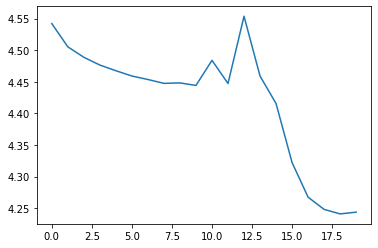

In [16]:
plt.plot(losses)

### Resource Estimate: 
Identify bottleneck in quantum classical hybrid models (number of learnt parameters in ansatz, gate overhead of encoding pixel values and size of dataset). Keep the classical layers not too deep to allow for efficient classical training. Explore the trade-off of number of run epochs and accuracy, the complexity/expressive power of the ansatz and the accuracy, number of quantum vs classical parameters and time complexity benchmark of the hybrid training loop time.

<img src="AmazonLambda.jpeg" width=50%, height=50% >

To achieve our goal, we defined a scenario in which we implement a classic convolutional network with the Tensorflow framework. The idea is to use the 4000 $ credit to use an AWS Lambda function controller in Python [3] and to parallelize. And also, for computing gradients in parallel with the Pennylane-Braket plugin.


## References

1. Liu, Junhua, et al. "Hybrid quantum-classical convolutional neural networks." arXiv preprint arXiv:1911.02998 (2019).

2. Henderson, Maxwell, et al. "Quanvolutional neural networks: powering image recognition with quantum circuits." Quantum Machine Intelligence 2.1 (2020): 1-9.

   
3. https://docs.aws.amazon.com/es_es/lambda/latest/dg/python-handler.html
